<a href="https://colab.research.google.com/github/lmarchyok/ICEsat-2/blob/main/Solar_Elevation_vs_Saturation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import pandas as pd
import os
import numpy as np
import zipfile
import h5py
import matplotlib.pylab as plt

In [77]:
from IPython.utils import strdispatch
class ICEsat_2_visualizer: 

  def __init__(self, data_dir: str, laser_id: str, var1: str, var2: str):
    self.data_dir = data_dir
    self.laser_id = laser_id
    self.var1 = var1
    self.var2 = var2

  def zip_extraction(self):

    destination_dir = '/content/drive/MyDrive/ICEsat-2/ICEsat-2_data_downloads/OR'

    zp = zipfile.ZipFile(self.data_dir)
    zp.extractall(destination_dir)
    
    for i in os.listdir(destination_dir):

      if i == 'Oregon_Data':
        continue
      elif i == 'IceSat2_Data_OR.pptx':
        continue
      elif i == '._IceSat2_Data_OR.pptx':
        continue 
      else:
        final = destination_dir + '/' + i
        finaldir = os.listdir(final)[0]
    return final + '/' + finaldir 

  def h5_extraction(self):

    with h5py.File(self.zip_extraction(), 'r') as f1:
        laser = f1.get(self.laser_id)
        laser_data = laser.get('geolocation')
        var1 = laser_data.get(self.var1)
        var2 = laser_data.get(self.var2)
        var1_arr = np.array(var1)
        var2_arr = np.array(var2)
    
    return (var1_arr, var2_arr)


  def plot_sat_vs_sol_elev(self, selims='auto'):

    if selims=='auto':
          lower = np.nanmin(self.h5_extraction()[1])
          upper = np.nanmax(self.h5_extraction()[1])
          serange = upper - lower
          selims = [lower - 0.2*serange, upper + 0.1*serange]

    lat_lower = np.nanmin(self.h5_extraction()[0])
    lat_upper = np.nanmax(self.h5_extraction()[0])
    latrange = lat_upper - lat_lower
    latlims = [lat_lower - 0.2 * latrange, lat_upper + 0.1 * latrange]

    print(lat_lower)
    print(lat_upper)

    fig = plt.figure(figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    solar_elevation = self.h5_extraction()[0]
    saturation = self.h5_extraction()[1]
    ax.set_title(f'{self.var1} vs {self.var2} over 700m')
    ax.set_xlabel('Solar Elevation (degrees)')
    ax.set_ylabel('Saturation (percentage)')

    atl03_plot = ax.scatter(solar_elevation, saturation, s=10,c='k',edgecolors='none',label=self.laser_id)
    ax.legend(handles=[atl03_plot], loc='lower left')
    ax.set_xlim(latlims)
    ax.set_ylim(selims)

    if not os.path.exists('figs'):
        os.makedirs('figs')
    fn = f'figs/atl03_plot_{self.var1}_vs_{self.var2}_{self.laser_id}.png'
    plt.savefig(fn, dpi=150)

24.244986
24.269262


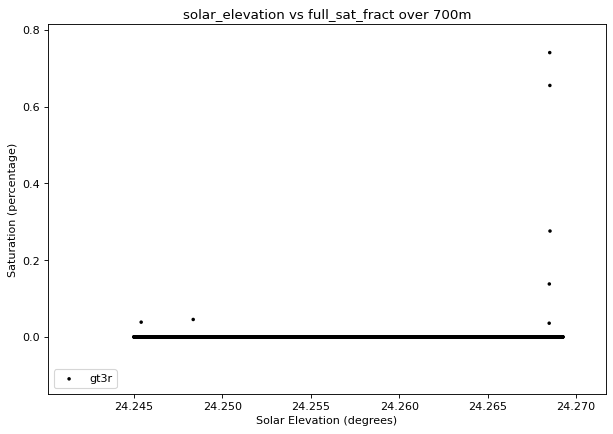

In [78]:
if __name__ == '__main__':
  zip_folder = '/content/drive/MyDrive/ICEsat-2/ICEsat-2_data_downloads/OR/Oregon_Data/5000003225149.zip'
  visualizer = ICEsat_2_visualizer(zip_folder, 'gt3r', 'solar_elevation', 'full_sat_fract')
  visualizer.zip_extraction()
  visualizer.h5_extraction()
  visualizer.plot_sat_vs_sol_elev()